# 3D Morphology Scaling Analysis

## Research Questions
- **H4**: Does thickness I₁ scale linearly with V^(1/3)?
- **H5**: Are aspect ratios (I₂/I₁, I₃/I₁) approximately constant across N?
- **H6**: Does density remain approximately constant as N increases?

## Method
- Use PCA ellipsoid proxy for all morphology metrics
- Burn-in: discard first 60% of frames
- Multiple seeds for robustness
- Periodic boundary unwrapping before PCA

In [6]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from src.flocking_sim_3d import run_simulation

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
})

print("Setup complete")

Setup complete


## 1. Core Functions

In [7]:
def unwrap_periodic(positions, box_size=1.0):
    """
    Unwrap periodic boundary conditions relative to center of mass.
    Critical for accurate PCA on wrapped coordinates.
    """
    pos = positions.copy()
    com = pos.mean(axis=0)
    
    for i in range(pos.shape[0]):
        diff = pos[i] - com
        diff -= box_size * np.round(diff / box_size)
        pos[i] = com + diff
    
    return pos

print("Function defined: unwrap_periodic")

Function defined: unwrap_periodic


In [8]:
def compute_pca_metrics(positions, box_size=1.0):
    """
    Compute PCA-based morphology metrics.
    
    Returns
    -------
    dict with keys:
        I1, I2, I3 : PCA axis lengths (sorted descending)
        V_ellipsoid : (4/3) * pi * I1 * I2 * I3
        I2_I1 : aspect ratio I2/I1
        I3_I1 : aspect ratio I3/I1
        density : N / V_ellipsoid
    """
    # Unwrap periodic boundaries
    pos_unwrapped = unwrap_periodic(positions, box_size)
    
    # Center
    pos_centered = pos_unwrapped - pos_unwrapped.mean(axis=0)
    
    # PCA
    cov = np.cov(pos_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    
    # Axis lengths (semi-axes)
    I1, I2, I3 = np.sqrt(eigvals)
    
    # Ellipsoid volume proxy
    V_ellipsoid = (4.0/3.0) * np.pi * I1 * I2 * I3
    
    # Density
    N = len(positions)
    density = N / V_ellipsoid if V_ellipsoid > 0 else 0
    
    return {
        'I1': I1,
        'I2': I2,
        'I3': I3,
        'V_ellipsoid': V_ellipsoid,
        'I2_I1': I2/I1 if I1 > 0 else 0,
        'I3_I1': I3/I1 if I1 > 0 else 0,
        'density': density
    }

print("Function defined: compute_pca_metrics")

Function defined: compute_pca_metrics


In [9]:
def collect_morphology_metrics(N, align=1.5, noise=0.10, n_seeds=5, 
                                burn_frac=0.6, steps=500, save_every=10):
    """
    Run simulations and collect morphology metrics with burn-in.
    
    Returns
    -------
    metrics_list : list of dicts
        Each dict contains metrics for one (seed, frame) combination
    """
    # Scaling: box_size ~ N^(1/3)
    box_size = N**(1.0/3.0)
    R = 0.15 * box_size
    repulsion_radius = 0.05 * box_size
    
    print(f"N={N}: box_size={box_size:.3f}, R={R:.3f}, r_rep={repulsion_radius:.3f}")
    
    metrics_list = []
    
    for seed in range(n_seeds):
        # Run simulation
        history = run_simulation(
            N=N,
            steps=steps,
            align=align,
            noise=noise,
            R=R,
            speed=0.03,
            repulsion_radius=repulsion_radius,
            repulsion_strength=1.0,
            box_size=box_size,
            seed=seed,
            save_every=save_every
        )
        
        # Burn-in: discard first 60%
        burn_idx = int(len(history) * burn_frac)
        tail_frames = history[burn_idx:]
        
        # Compute metrics for each tail frame
        for frame_idx, pos in enumerate(tail_frames):
            metrics = compute_pca_metrics(pos, box_size)
            metrics['N'] = N
            metrics['seed'] = seed
            metrics['frame'] = burn_idx + frame_idx
            metrics_list.append(metrics)
        
        print(f"  Seed {seed}: {len(tail_frames)} tail frames")
    
    return metrics_list

print("Function defined: collect_morphology_metrics")

Function defined: collect_morphology_metrics


## 2. Data Collection

In [10]:
# Size range
N_values = [100, 200, 400, 800]

# Collect data
all_metrics = []

for N in N_values:
    print(f"\n=== N = {N} ===")
    metrics = collect_morphology_metrics(
        N=N,
        align=1.5,
        noise=0.10,
        n_seeds=5,
        burn_frac=0.6,
        steps=500,
        save_every=10
    )
    all_metrics.extend(metrics)

# Convert to DataFrame
df = pd.DataFrame(all_metrics)

print(f"\nTotal data points: {len(df)}")
print(f"Columns: {df.columns.tolist()}")


=== N = 100 ===
N=100: box_size=4.642, R=0.696, r_rep=0.232
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 200 ===
N=200: box_size=5.848, R=0.877, r_rep=0.292
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 400 ===
N=400: box_size=7.368, R=1.105, r_rep=0.368
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 800 ===
N=800: box_size=9.283, R=1.392, r_rep=0.464
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

Total data points: 400
Columns: ['I1', 'I2', 'I3', 'V_ellipsoid', 'I2_I1', 'I3_I1', 'density', 'N', 'seed', 'frame']


In [11]:
# Aggregate: for each (N, seed), average over tail frames
df_per_seed = df.groupby(['N', 'seed']).agg({
    'I1': 'mean',
    'I2': 'mean',
    'I3': 'mean',
    'V_ellipsoid': 'mean',
    'I2_I1': 'mean',
    'I3_I1': 'mean',
    'density': 'mean'
}).reset_index()

# Aggregate: for each N, compute mean ± std across seeds
df_summary = df_per_seed.groupby('N').agg({
    'I1': ['mean', 'std'],
    'I2': ['mean', 'std'],
    'I3': ['mean', 'std'],
    'V_ellipsoid': ['mean', 'std'],
    'I2_I1': ['mean', 'std'],
    'I3_I1': ['mean', 'std'],
    'density': ['mean', 'std']
}).reset_index()

print("\nSummary statistics:")
print(df_summary)


Summary statistics:
     N        I1                  I2                  I3            \
            mean       std      mean       std      mean       std   
0  100  1.497844  0.194771  1.275258  0.083578  1.108957  0.086678   
1  200  1.909971  0.095730  1.599644  0.068509  1.327693  0.140515   
2  400  2.362610  0.125596  2.075256  0.052518  1.835787  0.133193   
3  800  3.001088  0.176450  2.655498  0.079372  2.283649  0.231503   

  V_ellipsoid               I2_I1               I3_I1              density  \
         mean       std      mean       std      mean       std       mean   
0    8.856499  1.359279  0.862909  0.113685  0.752439  0.118726  11.523199   
1   16.979453  1.995204  0.840224  0.071372  0.696642  0.082270  11.905698   
2   37.615902  2.220253  0.881098  0.062187  0.779919  0.082177  10.664954   
3   75.915302  5.220588  0.887750  0.066886  0.766529  0.119284  10.579378   

             
        std  
0  1.835593  
1  1.340947  
2  0.640266  
3  0.745762  


## 3. H4: Thickness I₁ vs V^(1/3)

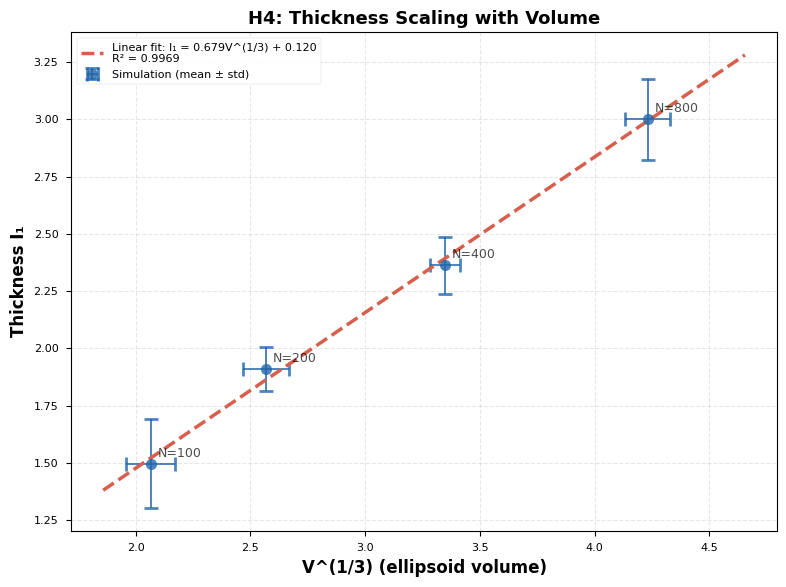


H4 Results:
  Slope: 0.6790 ± 0.0267
  R²: 0.9969
  p-value: 1.5397e-03


In [12]:
# Compute V^(1/3) for each seed
df_per_seed['V_cbrt'] = df_per_seed['V_ellipsoid'] ** (1.0/3.0)

# Aggregate for plotting
df_h4 = df_per_seed.groupby('N').agg({
    'V_cbrt': ['mean', 'std'],
    'I1': ['mean', 'std']
}).reset_index()

V_cbrt_mean = df_h4['V_cbrt']['mean'].values
V_cbrt_std = df_h4['V_cbrt']['std'].values
I1_mean = df_h4['I1']['mean'].values
I1_std = df_h4['I1']['std'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(V_cbrt_mean, I1_mean)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Data points with error bars
ax.errorbar(V_cbrt_mean, I1_mean, 
           xerr=V_cbrt_std, yerr=I1_std,
           fmt='o', markersize=8, capsize=5, capthick=2,
           color='#2166ac', ecolor='#2166ac', alpha=0.8,
           label='Simulation (mean ± std)')

# Linear fit
x_fit = np.linspace(V_cbrt_mean.min()*0.9, V_cbrt_mean.max()*1.1, 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, '--', color='#d6604d', linewidth=2.5,
       label=f'Linear fit: I₁ = {slope:.3f}V^(1/3) + {intercept:.3f}\nR² = {r_value**2:.4f}')

# Annotate N values
for i, N in enumerate(df_h4['N']):
    ax.annotate(f'N={N}', (V_cbrt_mean[i], I1_mean[i]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, alpha=0.7)

ax.set_xlabel('V^(1/3) (ellipsoid volume)', fontsize=12, weight='bold')
ax.set_ylabel('Thickness I₁', fontsize=12, weight='bold')
ax.set_title('H4: Thickness Scaling with Volume', fontsize=13, weight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nH4 Results:")
print(f"  Slope: {slope:.4f} ± {std_err:.4f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.4e}")

## 4. H5: Aspect Ratios vs N

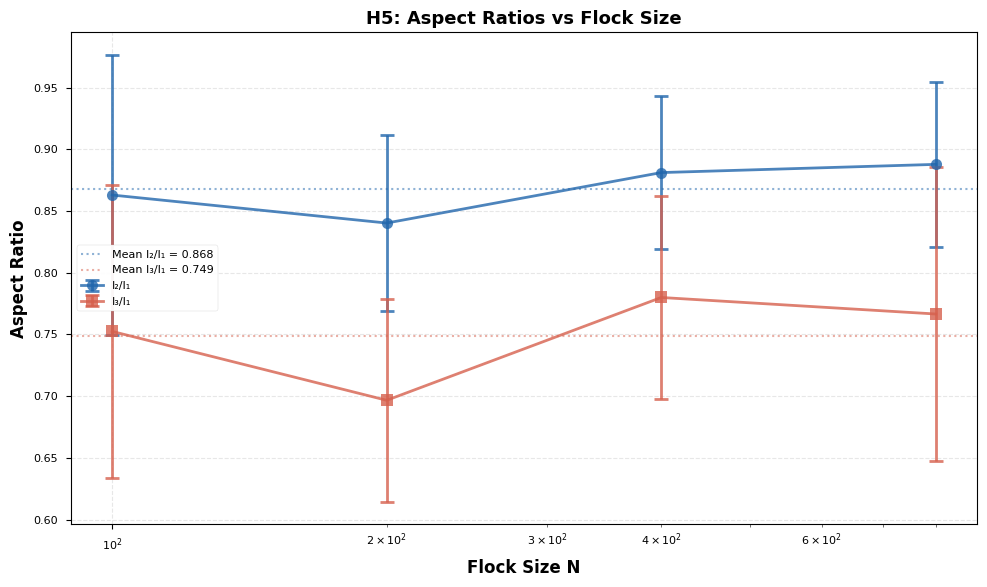


H5 Results:
  I₂/I₁: 0.8680 ± 0.0785
  I₃/I₁: 0.7489 ± 0.1006
  Coefficient of variation (I₂/I₁): 0.0905
  Coefficient of variation (I₃/I₁): 0.1344


In [13]:
# Extract data
N_vals = df_summary['N'].values
I2_I1_mean = df_summary['I2_I1']['mean'].values
I2_I1_std = df_summary['I2_I1']['std'].values
I3_I1_mean = df_summary['I3_I1']['mean'].values
I3_I1_std = df_summary['I3_I1']['std'].values

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# I2/I1
ax.errorbar(N_vals, I2_I1_mean, yerr=I2_I1_std,
           fmt='o-', markersize=8, capsize=5, capthick=2,
           linewidth=2, color='#2166ac', ecolor='#2166ac',
           label='I₂/I₁', alpha=0.8)

# I3/I1
ax.errorbar(N_vals, I3_I1_mean, yerr=I3_I1_std,
           fmt='s-', markersize=8, capsize=5, capthick=2,
           linewidth=2, color='#d6604d', ecolor='#d6604d',
           label='I₃/I₁', alpha=0.8)

# Reference lines (mean values)
ax.axhline(I2_I1_mean.mean(), color='#2166ac', linestyle=':', 
          linewidth=1.5, alpha=0.5, label=f'Mean I₂/I₁ = {I2_I1_mean.mean():.3f}')
ax.axhline(I3_I1_mean.mean(), color='#d6604d', linestyle=':', 
          linewidth=1.5, alpha=0.5, label=f'Mean I₃/I₁ = {I3_I1_mean.mean():.3f}')

ax.set_xlabel('Flock Size N', fontsize=12, weight='bold')
ax.set_ylabel('Aspect Ratio', fontsize=12, weight='bold')
ax.set_title('H5: Aspect Ratios vs Flock Size', fontsize=13, weight='bold')
ax.set_xscale('log')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nH5 Results:")
print(f"  I₂/I₁: {I2_I1_mean.mean():.4f} ± {I2_I1_std.mean():.4f}")
print(f"  I₃/I₁: {I3_I1_mean.mean():.4f} ± {I3_I1_std.mean():.4f}")
print(f"  Coefficient of variation (I₂/I₁): {I2_I1_std.mean()/I2_I1_mean.mean():.4f}")
print(f"  Coefficient of variation (I₃/I₁): {I3_I1_std.mean()/I3_I1_mean.mean():.4f}")

## 5. H6: Density vs N

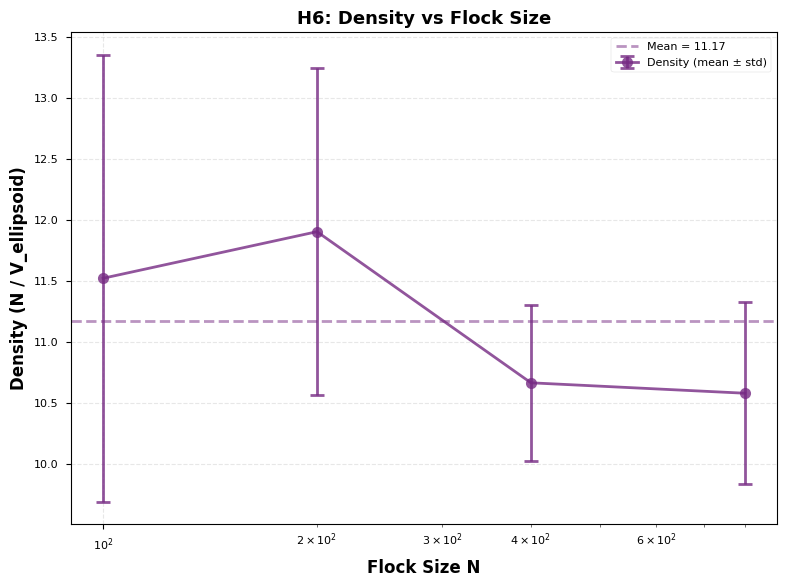


H6 Results:
  Mean density: 11.1683 ± 1.1406
  Coefficient of variation: 0.1021


In [14]:
# Extract data
density_mean = df_summary['density']['mean'].values
density_std = df_summary['density']['std'].values

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(N_vals, density_mean, yerr=density_std,
           fmt='o-', markersize=8, capsize=5, capthick=2,
           linewidth=2, color='#762a83', ecolor='#762a83',
           label='Density (mean ± std)', alpha=0.8)

# Reference line (mean density)
ax.axhline(density_mean.mean(), color='#762a83', linestyle='--',
          linewidth=2, alpha=0.5, label=f'Mean = {density_mean.mean():.2f}')

ax.set_xlabel('Flock Size N', fontsize=12, weight='bold')
ax.set_ylabel('Density (N / V_ellipsoid)', fontsize=12, weight='bold')
ax.set_title('H6: Density vs Flock Size', fontsize=13, weight='bold')
ax.set_xscale('log')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nH6 Results:")
print(f"  Mean density: {density_mean.mean():.4f} ± {density_std.mean():.4f}")
print(f"  Coefficient of variation: {density_std.mean()/density_mean.mean():.4f}")

## 6. Summary

In [15]:
# Create summary table
summary_table = pd.DataFrame({
    'N': N_vals,
    'I1_mean': df_summary['I1']['mean'].values,
    'I1_std': df_summary['I1']['std'].values,
    'V_cbrt_mean': V_cbrt_mean,
    'V_cbrt_std': V_cbrt_std,
    'I2_I1_mean': I2_I1_mean,
    'I2_I1_std': I2_I1_std,
    'I3_I1_mean': I3_I1_mean,
    'I3_I1_std': I3_I1_std,
    'density_mean': density_mean,
    'density_std': density_std
})

print("\nSummary Table:")
print(summary_table.to_string(index=False))

# Save
summary_table.to_csv('../results/3d_scaling_summary.csv', index=False)
print("\nSaved: ../results/3d_scaling_summary.csv")


Summary Table:
  N  I1_mean   I1_std  V_cbrt_mean  V_cbrt_std  I2_I1_mean  I2_I1_std  I3_I1_mean  I3_I1_std  density_mean  density_std
100 1.497844 0.194771     2.064530    0.107357    0.862909   0.113685    0.752439   0.118726     11.523199     1.835593
200 1.909971 0.095730     2.567158    0.099353    0.840224   0.071372    0.696642   0.082270     11.905698     1.340947
400 2.362610 0.125596     3.349564    0.066232    0.881098   0.062187    0.779919   0.082177     10.664954     0.640266
800 3.001088 0.176450     4.232442    0.097930    0.887750   0.066886    0.766529   0.119284     10.579378     0.745762

Saved: ../results/3d_scaling_summary.csv


In [ ]:
# Save raw data
df.to_csv('../results/3d_scaling_raw.csv', index=False)
df_per_seed.to_csv('../results/3d_scaling_per_seed.csv', index=False)

print("Saved:")
print("  ../results/3d_scaling_raw.csv")
print("  ../results/3d_scaling_per_seed.csv")